In [1]:
%matplotlib inline

In [62]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, MapDataset
from gammapy.data import Observation, observatory_locations
from regions import CircleSkyRegion
from scipy.stats import chi2, norm

import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit
from gammapy.catalog import CATALOG_REGISTRY, SourceCatalogHGPS

In [63]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 1.0        
	path                   : /Users/ASinha/opt/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy 



In [64]:
print(CATALOG_REGISTRY)
catalog=SourceCatalogHGPS()
source = catalog[3]

model = source.sky_model()
print(model)

Registry
--------

SourceCatalogGammaCat: gamma-cat 
SourceCatalogHGPS    : hgps 
SourceCatalog2HWC    : 2hwc 
SourceCatalog3FGL    : 3fgl 
SourceCatalog4FGL    : 4fgl 
SourceCatalog2FHL    : 2fhl 
SourceCatalog3FHL    : 3fhl 
SourceCatalog3HWC    : 3hwc 

SkyModel

  Name                      : HESS J1018-589 B
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.196   +/-    0.09             
    amplitude                     :   9.15e-14   +/- 1.1e-14 1 / (cm2 s TeV)
    reference             (frozen):      2.742       TeV         
    lon_0                         :    284.223   +/-    0.04 deg         
    lat_0                         :     -1.772   +/-    0.03 deg         
    sigma                         :      0.150   +/-    0.03 deg         
    e                     (frozen):      0.000                  

In [65]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [66]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 6.0*u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [67]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [68]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.25
	duration          : 21600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [69]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

In [119]:
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
#bkg_model.spectral_model.norm.value = np.random.normal(1,0.1)
#bkg_model.spectral_model.tilt.value = np.random.normal(0,0.05)
spectral_model=PowerLawSpectralModel(
    amplitude="1e-12 cm-2 s-1 TeV-1", index=2, reference="1 TeV"
)
spatial_model=GaussianSpatialModel(
    lon_0="0.4 deg", lat_0="-0.6 deg", sigma="0.1 deg", frame="galactic"  
)
spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5
spatial_model.lat_0.min = spatial_model.lat_0.value - 0.5
spatial_model.lat_0.max = spatial_model.lat_0.value + 0.5

spatial_model.sigma.value = 2.0

model_simu = SkyModel(spectral_model, spatial_model)
Models([bkg_model, model_simu]).parameters.to_table()


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,int64,float64,float64,bool,bool,str1
spectral,norm,1.0000e+00,,0.000e+00,nan,nan,False,True,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,index,2.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spatial,lon_0,4.0000e-01,deg,0.000e+00,-1.000e-01,9.000e-01,False,False,
spatial,lat_0,-6.0000e-01,deg,0.000e+00,-1.100e+00,-1.000e-01,False,False,
spatial,sigma,2.0000e+00,deg,0.000e+00,0.000e+00,nan,False,False,


In [90]:
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)



dataset.models =  Models([bkg_model, model_simu])
dataset.fake()


# -- like an observation
dataset.models =  Models([bkg_model])  


fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=dataset)
L0 = result.total_stat
print(L0)

model = model_simu.copy(name="model_fit")
model.spatial_model.lon_0.min = -1.5
model.spatial_model.lon_0.max = 1.5
model.spatial_model.lat_0.min = -1.5
model.spatial_model.lat_0.max = 1.5

model.spectral_model.index.min = 0.0
dataset.models = Models([bkg_model, model])



fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=dataset)
L1 = result.total_stat
print(L1)
TS=L0-L1

615651.9159939517
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 9.89708 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 24.8187
W VariableMetricBuilder gdel = -132.295
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 316.982 Requested 0.0002
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.060468
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.0603328
W MnPosDef Added to diagonal of Error matrix a value 0.560469
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 17.0421 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W MnPosDef Matrix forced pos-de

In [91]:
TS

-185.92131827690173

In [92]:
result.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,9.9635e-01,,1.219e-03,nan,nan,False,True,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,index,1.2750e+00,,4.348e-01,0.000e+00,nan,False,False,
spectral,amplitude,6.8264e-13,cm-2 s-1 TeV-1,9.832e-13,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spatial,lon_0,1.4996e+00,deg,1.435e-02,-1.500e+00,1.500e+00,False,False,
spatial,lat_0,1.4998e+00,deg,2.578e-03,-1.500e+00,1.500e+00,False,False,
spatial,sigma,4.2373e-01,deg,1.485e-01,0.000e+00,nan,False,False,


In [93]:
result.models[1].parameters["amplitude"].error, result.models[1].parameters["amplitude"].value

(9.832493053574645e-13, 6.826359794134962e-13)

In [94]:
model = result.models[1]

<WCSAxesSubplot: >

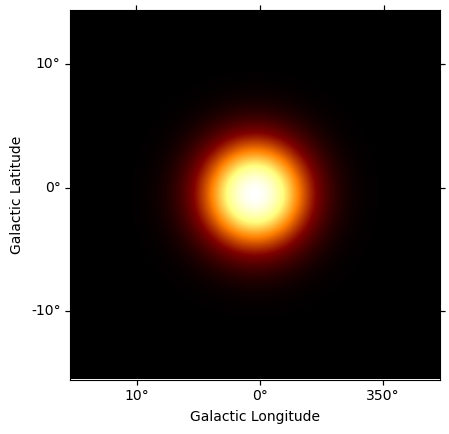

In [95]:
model_simu.spatial_model.plot()

<WCSAxesSubplot: >

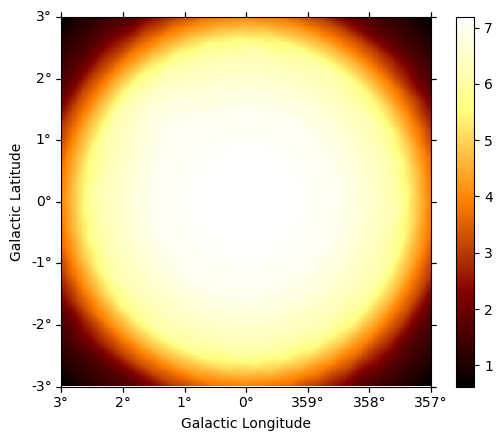

In [96]:
dataset.npred().sum_over_axes().plot(add_cbar=True)

<WCSAxesSubplot: >

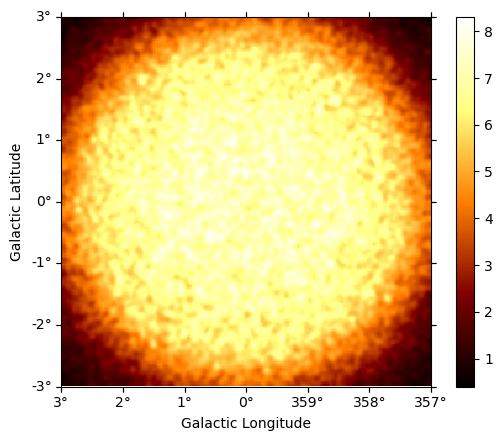

In [97]:
dataset.counts.sum_over_axes().smooth(0.04*u.deg).plot(add_cbar=True)

In [99]:
fpe = FluxPointsEstimator(energy_edges=energy_reco.edges, source=model.name, reoptimize=False)
flux_points = fpe.run(dataset)

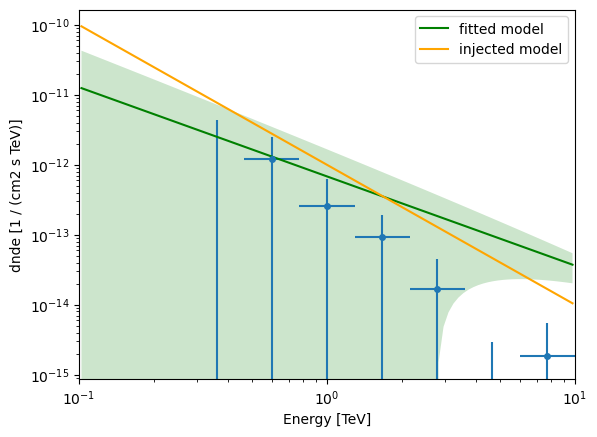

In [105]:
ax = flux_points.plot()
model.spectral_model.plot(ax=ax, energy_bounds=[0.1, 10]*u.TeV, label="fitted model", color="green")
model.spectral_model.plot_error(ax=ax, energy_bounds=[0.1, 10]*u.TeV, facecolor="green")

model_simu.spectral_model.plot(ax=ax, energy_bounds=[0.1, 10]*u.TeV, label="injected model", color="orange")
model_simu.spectral_model.plot_error(ax=ax, energy_bounds=[0.1, 10]*u.TeV, facecolor="orange")
plt.legend()



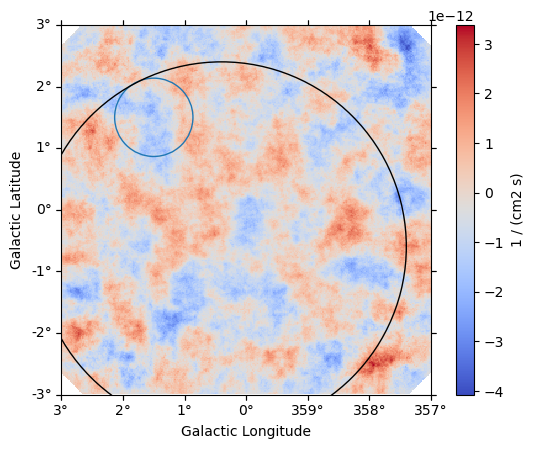

In [120]:
dataset2 = dataset.copy()
dataset2.models = None
from gammapy.estimators import *
est = ExcessMapEstimator(correlation_radius=0.3*u.deg)
res = est.run(dataset2)
ax = res["flux"].plot(add_cbar=True, cmap="coolwarm")
dataset.models.plot_regions(ax=ax)
model_simu.spatial_model.to_region().to_pixel(ax.wcs).plot()

In [112]:
dataset.models.plot_regions??

Signature:
dataset.models.plot_regions(
    ax=None,
    kwargs_point=None,
    path_effect=None,
    **kwargs,
)
Source:   
    def plot_regions(self, ax=None, kwargs_point=None, path_effect=None, **kwargs):
        """Plot extent of the spatial models on a given wcs axis

        Parameters
        ----------
        ax : `~astropy.visualization.WCSAxes`
            Axes to plot on. If no axes are given, an all-sky wcs
            is chosen using a CAR projection
        kwargs_point : dict
            Keyword arguments passed to `~matplotlib.lines.Line2D` for plotting
            of point sources
        path_effect : `~matplotlib.patheffects.PathEffect`
            Path effect applied to artists and lines.
        **kwargs : dict
            Keyword arguments passed to `~matplotlib.artists.Artist`


        Returns
        -------
        ax : `~astropy.visualization.WcsAxes`
            WCS axes
        """
        regions = self.to_regions()

        geom = RegionGeom.from_region

In [15]:
dataset

In [16]:
def sigma_to_ts(sigma, df=1):
    """Convert sigma to delta ts"""
    p_value = 2 * norm.sf(sigma)
    return chi2.isf(p_value, df=df)

def ts_to_sigma(ts, df=1):
    """Convert delta ts to sigma"""
    p_value = chi2.sf(ts, df=df)
    return norm.isf(0.5 * p_value)

sigma=ts_to_sigma(TS,6)
print(sigma)

29.35294230220207
